In [1]:
import numpy as np
import matplotlib.pyplot as plt
import psyplot.project as psy
from toolbox import add_grid_info2, ind_from_latlon

In [2]:
# grid file
f_g = '/store/mch/msopr/swester/grids/grid_r19b07_midnight.nc'

# output file
f_o = '/scratch/swester/icon-losvec/pgi_cpu/experiments/losvec_r19b07/losvec_r19b07_atm_3d_ml_20211125T000010Z.nc'

In [3]:
ds_grid = psy.open_dataset(f_g).squeeze()
ds_vars = psy.open_dataset(f_o).squeeze()

In [4]:
ds = add_grid_info2(f_o, f_g)
ds

<xarray.Dataset>
Dimensions:                        (cell: 11468, vertices: 3, height: 80, bnds: 2, height_2: 81, vertex: 5890, edge: 17357, nv: 3, nc: 2, ne: 6, no: 4, max_chdom: 1, cell_grf: 14, edge_grf: 24, vert_grf: 13)
Coordinates: (12/19)
    clon                           (cell) float32 ...
    clon_bnds                      (cell, vertices) float32 ...
    clat                           (cell) float32 ...
    clat_bnds                      (cell, vertices) float32 ...
  * height                         (height) float64 1.0 2.0 3.0 ... 79.0 80.0
    height_bnds                    (height, bnds) float64 ...
    ...                             ...
    clon_vertices                  (cell, nv) float64 ...
    clat_vertices                  (cell, nv) float64 ...
    elon_vertices                  (edge, no) float64 ...
    elat_vertices                  (edge, no) float64 ...
    vlon_vertices                  (vertex, ne) float64 ...
    vlat_vertices                  (vertex, ne) float64 ...
Dimensions without coordinates: cell, vertices, bnds, vertex, edge, nv, nc, ne, no, max_chdom, cell_grf, edge_grf, vert_grf
Data variables: (12/48)
    T                              (height, cell) float64 ...
    HSURF                          (cell) float64 ...
    HHL                            (height_2, cell) float64 ...
    cartesian_x_vertices           (vertex) float64 ...
    cartesian_y_vertices           (vertex) float64 ...
    cartesian_z_vertices           (vertex) float64 ...
    ...                             ...
    end_idx_e                      (max_chdom, edge_grf) int32 ...
    refin_v_ctrl                   (vertex) int32 ...
    start_idx_v                    (max_chdom, vert_grf) int32 ...
    end_idx_v                      (max_chdom, vert_grf) int32 ...
    parent_edge_index              (edge) int32 ...
    parent_vertex_index            (vertex) int32 ...
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    number_of_grid_used:  1
    uuidOfHGrid:          ff045f12-2e63-ec06-266b-f9be89ea24a0
    uuidOfVGrid:          e61bf310-0120-1f30-ca51-7112cd592ae0
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-nwp.git@a061c5f3be26a8...
    history:              /scratch/swester/icon-losvec/pgi_cpu/bin/icon at 20...
    references:           see MPIM/DWD publications
    comment:              Stephanie Westerhuis, MCH (swester) on tsa-pp014 (L...

psyplot.project.Project([    arr0: 1-dim DataArray of HSURF, with (cell)=(11468,), time=2021-11-25T00:00:11])

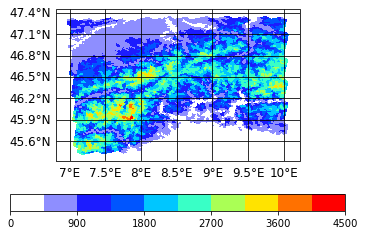

In [5]:
psy.plot.mapplot(ds, name='HSURF')

psyplot.project.Project([    arr1: 1-dim DataArray of HSURF, with (cell)=(11468,), time=2021-11-25T00:00:11])

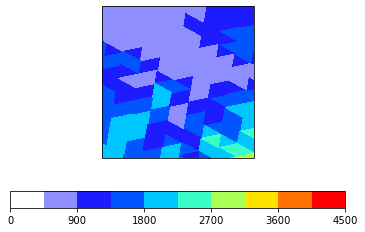

In [6]:
psy.plot.mapplot(ds, name='HSURF', map_extent=[7.5,7.8,46.5,46.8], xgrid=False, ygrid=False)

In [7]:
lat, lon = 46.77884, 7.63525 # Steffisburg
lats = np.rad2deg(ds.clat.values)
lons = np.rad2deg(ds.clon.values)
ind = ind_from_latlon(lats, lons, lat, lon)
print(f'Location of Steffisburg: {ind}')

Location of Steffisburg: 9237


psyplot.project.Project([    arr9: 1-dim DataArray of HSURF2, with (cell)=(11468,), time=2021-11-25T00:00:11])

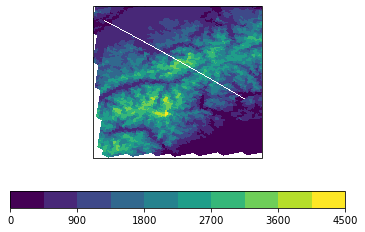

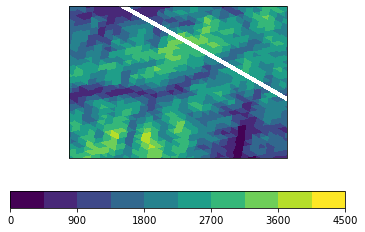

In [40]:
# find line
###########

# number of grid cells
N = ds.HSURF.size

# initialise mask
mask = np.ones(N)

# mark line with nan
mask[ind] = np.nan

# triangle collection index
index_pattern_se = [2,1] * 35
index_list_se = np.empty(70, dtype=int)
index_pattern_nw = [1,2] * 15
index_list_nw = np.empty(30, dtype=int)

# extend in south-east direction
new_index = ind
for e, i in enumerate(index_pattern_se):
    neighbors = ds.neighbor_cell_index.isel(cell=new_index).values
    new_index = neighbors[i] - 1
    index_list_se[e] = new_index
    mask[new_index] = np.nan

# extend in northwest direction
new_index = ind
for e,i in enumerate(index_pattern_nw):
    neighbors = ds.neighbor_cell_index.isel(cell=new_index).values
    new_index = neighbors[i] - 1
    index_list_nw[e] = new_index
    mask[new_index] = np.nan

# create new HSURF with masked line
ds = ds.assign(HSURF2=ds['HSURF']*mask)
ds.HSURF2.encoding["coordinates"] = 'clat clon'

# plot new HSURF
psy.plot.mapplot(ds, name='HSURF2',map_extent=[7.0,9.0,45.4,47.2], xgrid=False, ygrid=False, cmap='viridis')
psy.plot.mapplot(ds, name='HSURF2',map_extent=[7.5,8.5,46,46.7], xgrid=False, ygrid=False, cmap='viridis')
#ds.HSURF2


In [41]:
ind_line = np.append(np.append(index_list_nw, np.array(ind)), index_list_se)

In [55]:
hsurf = ds.HSURF.values
hhl = ds.HHL.values
oro = hsurf[ind_line]
vcoords = hhl[:,ind_line]
vcoords.shape

(81, 101)

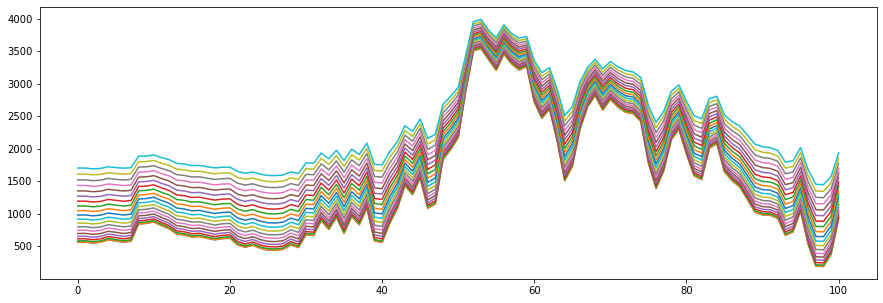

In [60]:
fig, ax = plt.subplots(figsize = (15,5))
plt.plot(oro)
for i in range(1,20):
    plt.plot(vcoords[-i,:])